Example notebook for using CMBBEST for targeted analysis

Study bispectrum shapes $S(k_1,k_2,k_3) = A(k_1, k_2, k_3) \sin (\omega (k_1 + k_2 + k_3) + \phi)$ for some smooth envelope $A$ and fixed $\omega$.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cmbbest as best

# Data settings
p_max = 10
Nk = 200
omega = 1000


# Prepare basis
basis_TP = best.Basis("SineLegendre1000", mode_p_max=p_max, polarisation_on=True)
n_s, A_s, k_pivot = basis_TP.parameter_n_scalar, basis_TP.parameter_A_scalar, basis_TP.parameter_k_pivot
prefactor = 6 * (A_s ** 2) * pow(k_pivot, 2 * (1 - n_s))

# Prepare models
models = []

# Standard shapes
shapes = ["local", "equilateral", "orthogonal"]
models = models + [best.Model(shape, parameter_n_scalar=n_s, parameter_A_scalar=A_s) for shape in shapes]

# Constant
models = models + [best.Model("custom_shape_function", custom_shape_function=(lambda k1,k2,k3: prefactor*np.ones_like(k1)), shape_name=f"Constant", parameter_n_scalar=n_s, parameter_A_scalar=A_s)]

# Exponential envelopes
def envelope_function(k0=0.05, width=2e-2):
    def envelope(k1, k2, k3):
        return prefactor * np.exp(-(((k1 + k2 + k3) / 3) - k0) ** 2 / (2 * width ** 2))
    return envelope

#k0s = np.linspace(0.01, 0.1, 10)
k0s = [0.05]
models = models + [best.Model("custom_shape_function", custom_shape_function=envelope_function(k0), shape_name=f"Envelope {k0:.2f}", parameter_n_scalar=n_s, parameter_A_scalar=A_s) for k0 in k0s]


Gamma and beta data loaded
1D mode functions evaluated
SineLegendre1000 Basis is now ready


In [2]:
# Compute shape covariance
coeff, shape_cov, conv_corr, conv_MSE = basis_TP.modal_decomposition(models, check_convergence=True)

S has shape (5, 681750)
QS Function start!
QS start!
220 10 200 681750 5
done!
Shape #1/5 decomposed using CG with exit code 2200
Shape #2/5 decomposed using CG with exit code 2200
Shape #3/5 decomposed using CG with exit code 2200
Shape #4/5 decomposed using CG with exit code 0
Shape #5/5 decomposed using CG with exit code 2200
Decomposition complete.


In [3]:
# Constrain models
result_TP = basis_TP.constrain_models(models, decomposition_coefficients=coeff, convergence_correlation=conv_corr, convergence_MSE=conv_MSE, full_result=False)
result_TP_full = basis_TP.constrain_models(models, decomposition_coefficients=coeff, convergence_correlation=conv_corr, convergence_MSE=conv_MSE, full_result=True)

NOTE: coefficients converted for sine-Legendre basis
NOTE: coefficients converted for sine-Legendre basis


In [4]:
# Show results
pd.set_option("display.precision", 2)  
result_TP["S/N"] = result_TP["single_f_NL"] / result_TP["single_sample_sigma"]
result_TP[["shape_name", "convergence_MSE", "single_f_NL", "single_sample_sigma", "S/N", "marginal_f_NL", "marginal_sample_sigma"]]


,shape_name,convergence_MSE,single_f_NL,single_sample_sigma,S/N,marginal_f_NL,marginal_sample_sigma
0,local sin,2.57e-04,-0.39,0.97,-0.40,1.03,3.84
1,local cos,2.57e-04,-1.41,1.10,-1.29,0.72,4.23
2,equilateral sin,2.11e-07,0.29,0.32,0.91,-14.64,21.40
3,equilateral cos,2.11e-07,0.48,0.45,1.05,-10.04,13.41
4,orthogonal sin,1.69e-05,0.10,0.12,0.91,5.29,7.86
5,orthogonal cos,1.69e-05,0.16,0.16,0.99,3.71,4.98
6,Constant sin,3.38e-06,-17.19,13.97,-1.23,-25.83,76.75
7,Constant cos,3.38e-06,11.51,15.05,0.76,155.75,60.65
8,Envelope 0.05 sin,1.13e-05,-13.62,26.49,-0.51,5.87,159.34
9,Envelope 0.05 cos,1.13e-05,-15.86,24.07,-0.66,-244.41,100.45


In [5]:
print(result_TP[["shape_name", "single_f_NL", "single_sample_sigma", "S/N"]].to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
       shape\_name &  single\_f\_NL &  single\_sample\_sigma &   S/N \\
\midrule
        local sin &        -0.39 &                 0.97 & -0.40 \\
        local cos &        -1.41 &                 1.10 & -1.29 \\
  equilateral sin &         0.29 &                 0.32 &  0.91 \\
  equilateral cos &         0.48 &                 0.45 &  1.05 \\
   orthogonal sin &         0.10 &                 0.12 &  0.91 \\
   orthogonal cos &         0.16 &                 0.16 &  0.99 \\
     Constant sin &       -17.19 &                13.97 & -1.23 \\
     Constant cos &        11.51 &                15.05 &  0.76 \\
Envelope 0.05 sin &       -13.62 &                26.49 & -0.51 \\
Envelope 0.05 cos &       -15.86 &                24.07 & -0.66 \\
\bottomrule
\end{tabular}



/var/folders/cp/q0v_t5w556s60f4_wf78xysr0000gn/T/ipykernel_93426/826521766.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(result_TP[["shape_name", "single_f_NL", "single_sample_sigma", "S/N"]].to_latex(index=False))


In [19]:
display(result_TP[["shape_name", "marginal_f_NL", "marginal_sample_sigma", "S/N"]])
#print(result_TP[["shape_name", "marginal_f_NL", "marginal_sample_sigma", "S/N"]].to_latex(index=False))

,shape_name,marginal_f_NL,marginal_sample_sigma,S/N
0,local sin,1.03,3.84,-0.40
1,local cos,0.72,4.23,-1.29
2,equilateral sin,-14.64,21.40,0.91
3,equilateral cos,-10.04,13.41,1.05
4,orthogonal sin,5.29,7.86,0.91
5,orthogonal cos,3.71,4.98,0.99
6,Constant sin,-25.83,76.75,-1.23
7,Constant cos,155.75,60.65,0.76
8,Envelope 0.05 sin,5.87,159.34,-0.51
9,Envelope 0.05 cos,-244.41,100.45,-0.66


In [6]:
df = result_TP_full

fNL_corr = pd.pivot_table(df, values="single_f_NL", columns="shape_name", index="map_number", sort=False).corr()
fNL_corr

shape_name,local sin,local cos,equilateral sin,equilateral cos,orthogonal sin,orthogonal cos,Constant sin,Constant cos,Envelope 0.05 sin,Envelope 0.05 cos
shape_name,,,,,,,,,,
local sin,1.00,0.49,-0.93,-0.41,-0.92,-0.43,-0.27,0.40,-0.30,0.60
local cos,0.49,1.00,-0.44,-0.88,-0.43,-0.88,-0.29,-0.14,-0.37,0.12
equilateral sin,-0.93,-0.44,1.00,0.41,1.00,0.42,0.05,-0.47,0.13,-0.70
equilateral cos,-0.41,-0.88,0.41,1.00,0.40,1.00,0.16,-0.11,0.23,-0.32
orthogonal sin,-0.92,-0.43,1.00,0.40,1.00,0.41,0.03,-0.48,0.11,-0.71
orthogonal cos,-0.43,-0.88,0.42,1.00,0.41,1.00,0.17,-0.13,0.24,-0.33
Constant sin,-0.27,-0.29,0.05,0.16,0.03,0.17,1.00,0.35,0.93,0.30
Constant cos,0.40,-0.14,-0.47,-0.11,-0.48,-0.13,0.35,1.00,0.37,0.90
Envelope 0.05 sin,-0.30,-0.37,0.13,0.23,0.11,0.24,0.93,0.37,1.00,0.23


In [7]:
print(fNL_corr.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
shape\_name &  local sin &  local cos &  equilateral sin &  equilateral cos &  orthogonal sin &  orthogonal cos &  Constant sin &  Constant cos &  Envelope 0.05 sin &  Envelope 0.05 cos \\
shape\_name        &            &            &                  &                  &                 &                 &               &               &                    &                    \\
\midrule
local sin         &       1.00 &       0.49 &            -0.93 &            -0.41 &           -0.92 &           -0.43 &         -0.27 &          0.40 &              -0.30 &               0.60 \\
local cos         &       0.49 &       1.00 &            -0.44 &            -0.88 &           -0.43 &           -0.88 &         -0.29 &         -0.14 &              -0.37 &               0.12 \\
equilateral sin   &      -0.93 &      -0.44 &             1.00 &             0.41 &            1.00 &            0.42 &          0.05 &         -0.47 &               0.13 &      

/var/folders/cp/q0v_t5w556s60f4_wf78xysr0000gn/T/ipykernel_93426/4220956130.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(fNL_corr.to_latex())


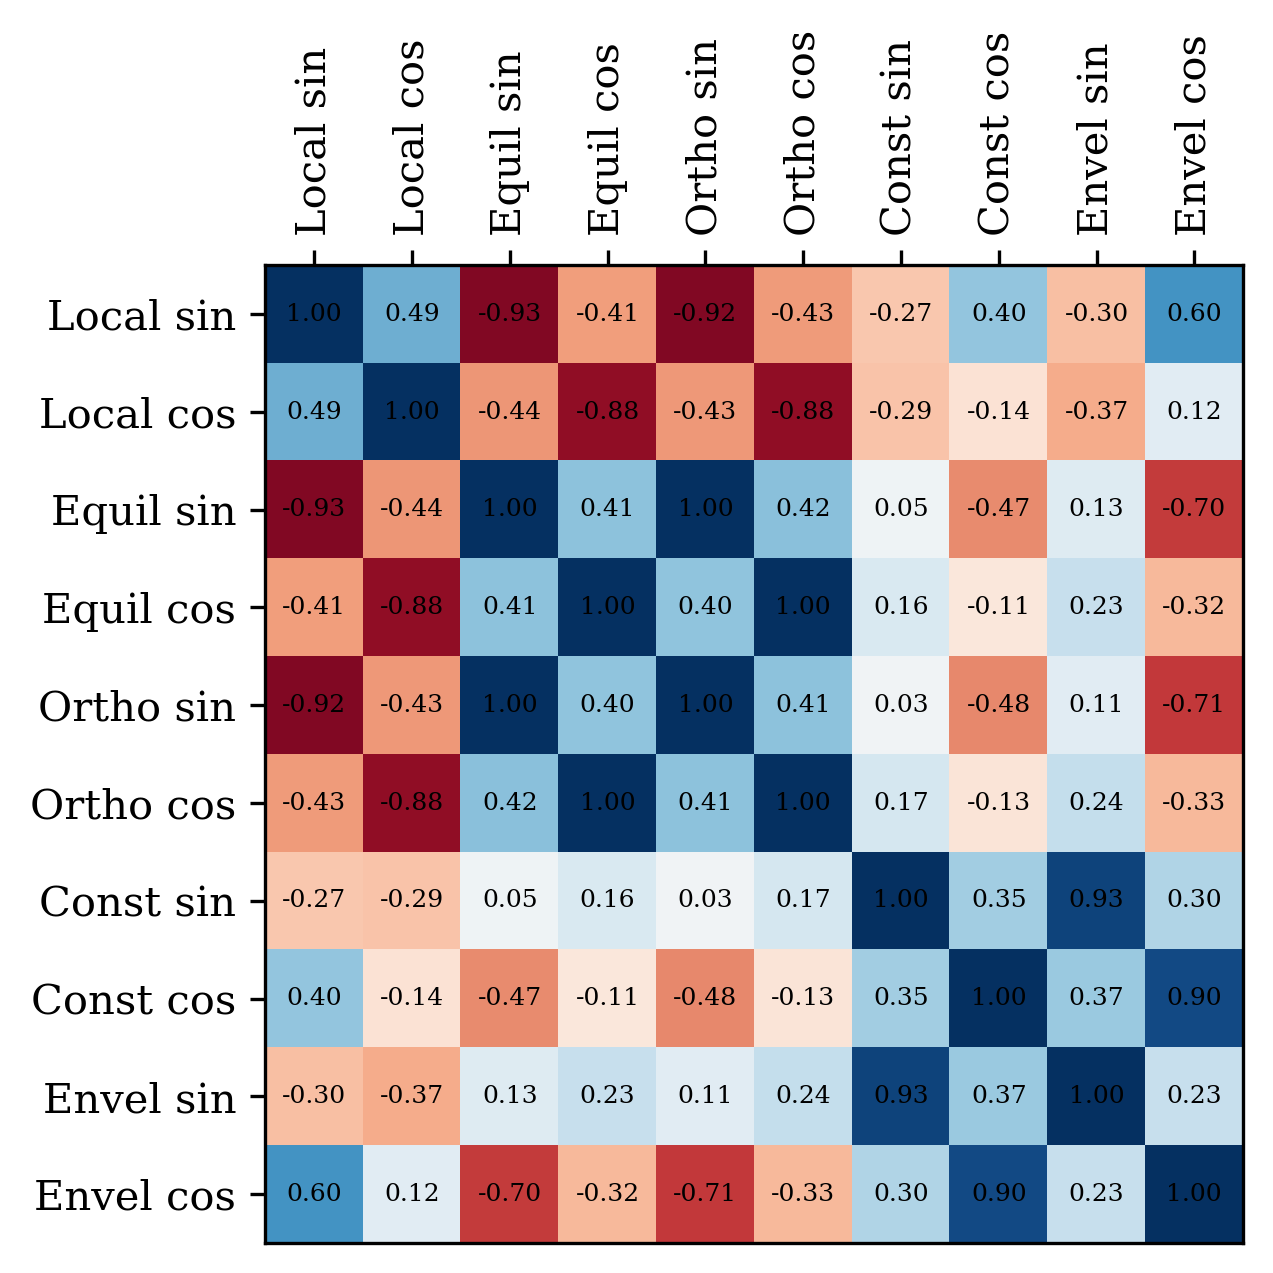

In [16]:
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 10,
    "axes.labelsize": 8,
    "legend.fontsize": 6,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "font.sans-serif": "Computer Modern Roman",
    "figure.dpi": 300,
    "savefig.bbox": "tight"})
fig_width_pt = 437     #437.46112
fig_width_in = fig_width_pt / 72.27


#shapes = ["Local", "Equilateral", "Orthogonal", "Constant", "Envelope"]
shapes = ["Local", "Equil", "Ortho", "Const", "Envel"]
shape_names = [shape+" "+phase for shape in shapes for phase in ["sin", "cos"]]

corr = fNL_corr.to_numpy()
fig, ax = plt.subplots(figsize=(0.7*fig_width_in, 0.7*fig_width_in))
im = ax.imshow(corr, vmin=-1, vmax=1, cmap="RdBu")
#fig.colorbar(im)
ax.set_xticks(ticks=np.arange(len(shape_names)), labels=shape_names, rotation=90)
ax.xaxis.tick_top()
ax.set_yticks(ticks=np.arange(len(shape_names)), labels=shape_names)
for i in range(len(shape_names)):
    for j in range(len(shape_names)):
        ax.text(i, j, "{:.2f}".format(corr[i,j]), ha="center", va="center", fontdict={"size": 6})

plt.savefig("data/sinleg_f_NL_correlations.pdf")

In [33]:
# Subset of models

models = []
# Standard shapes
shapes = ["local", "equilateral"]
models = models + [best.Model(shape, parameter_n_scalar=n_s, parameter_A_scalar=A_s) for shape in shapes]

# Constant
#models = models + [best.Model("custom_shape_function", custom_shape_function=(lambda k1,k2,k3: prefactor*np.ones_like(k1)), shape_name=f"Constant", parameter_n_scalar=n_s, parameter_A_scalar=A_s)]

# Compute shape covariance
coeff, shape_cov, conv_corr, conv_MSE = basis_TP.modal_decomposition(models, check_convergence=True)

# Constrain models
result_TP = basis_TP.constrain_models(models, decomposition_coefficients=coeff, convergence_correlation=conv_corr, convergence_MSE=conv_MSE, full_result=False)
result_TP_full = basis_TP.constrain_models(models, decomposition_coefficients=coeff, convergence_correlation=conv_corr, convergence_MSE=conv_MSE, full_result=True)

S has shape (2, 681750)
QS Function start!
QS start!
220 10 200 681750 2
done!
Shape #1/2 decomposed using CG with exit code 2200
Shape #2/2 decomposed using CG with exit code 2200
Decomposition complete.
NOTE: coefficients converted for sine-Legendre basis
NOTE: coefficients converted for sine-Legendre basis


In [34]:
# Show results
pd.set_option("display.precision", 2)  
result_TP["S/N"] = result_TP["single_f_NL"] / result_TP["single_sample_sigma"]
result_TP[["shape_name", "convergence_MSE", "single_f_NL", "single_sample_sigma", "S/N", "marginal_f_NL", "marginal_sample_sigma"]]

,shape_name,convergence_MSE,single_f_NL,single_sample_sigma,S/N,marginal_f_NL,marginal_sample_sigma
0,local sin,2.57e-04,-0.39,0.97,-0.40,4.29,2.62
1,local cos,2.57e-04,-1.41,1.10,-1.29,-3.37,2.88
2,equilateral sin,2.11e-07,0.29,0.32,0.91,1.27,0.78
3,equilateral cos,2.11e-07,0.48,0.45,1.05,-0.72,1.06


In [35]:
import itertools

def tensor_prod_coeffs(coeffs_1, coeffs_2, pmax_1, pmax_2):
    # Given S(k1,k2,k3) = S1(k1,k2,k3) * S2(k1,k2,k3)
    #                   = (x_abc q_a q_b q_c) * (y_def r_d r_e r_f),
    #                   = z_{(ad)(be)(cf)} (q_a r_d) (q_b r_e) (q_c r_f)
    # Compute z, the tensor product coefficient.
    # Assumes that coeffs_1 and coeffs_2 have the last axis length of pmax_1**3, pmax_2**3.

    tot_pmax = pmax_1 * pmax_2
    tot_coeffs = np.ones((coeffs_1.shape[0], tot_pmax**3), dtype=float)

    inds = np.arange(tot_coeffs.shape[1])

    ad_inds = inds // tot_pmax // tot_pmax
    a_inds = ad_inds // pmax_2
    d_inds = ad_inds % pmax_2

    be_inds = (inds // tot_pmax) % tot_pmax
    b_inds = be_inds // pmax_2
    e_inds = be_inds % pmax_2

    cf_inds = inds % tot_pmax
    c_inds = cf_inds // pmax_2
    f_inds = cf_inds % pmax_2

    abc_inds = a_inds * pmax_1**2 + b_inds * pmax_1 + c_inds
    def_inds = d_inds * pmax_2**2 + e_inds * pmax_2 + f_inds

    tot_coeffs[:,:] = coeffs_1[:,abc_inds] * coeffs_2[:,def_inds]

    return tot_coeffs

# First, extend the coefficients to shape (p_max**3)
p1, p2, p3 = basis_TP.mode_indices
sym_fact = basis_TP.mode_symmetry_factor
p_max = basis_TP.mode_p_max

full_coeffs = np.zeros((coeff.shape[0], p_max ** 3))
for pp1, pp2, pp3 in itertools.permutations([p1, p2, p3]):
    full_coeffs[:,(pp1 * p_max ** 2 + pp2 * p_max + pp3)] = coeff[:,:] / sym_fact[np.newaxis,:]

# Take tensor product with sinusoidal coeffs (p_max = 2)
# S(k1,k2,k3) = A(k1,k2,k3) * sin(w(k1+k2+k3) + phase)
def sine_coeff(phase):
    phase *= np.pi / 180.0  # degrees to radians
    sinp, cosp = np.sin(phase), np.cos(phase)
    # Im[exp(i(k1+k2+k3+phase))] = sinp * Re[...] + cosp * Im[...]
    # sss ssc scs scc css csc ccs ccc
    return np.array([-cosp, -sinp, -sinp, cosp, -sinp, cosp, cosp, sinp])

# Create two (sin and cos) coefficients per each row
full_coeffs = np.repeat(full_coeffs, 2, axis=0)
sin_coeffs = np.tile(np.array([sine_coeff(0), sine_coeff(90)]), (coeff.shape[0], 1))

# Tensor product on coefficients
sinleg_coeffs = tensor_prod_coeffs(full_coeffs, sin_coeffs, p_max, 2)

# Reduce the coefficients to shape (n_modes) corresponding to 2*p_max
new_mode_inds, new_sym_fact = basis_TP.create_mode_indices(p_max=2*basis_TP.mode_p_max)
q1, q2, q3 = new_mode_inds

coeff = np.zeros((sinleg_coeffs.shape[0], q1.shape[0]))
for qq1, qq2, qq3 in itertools.permutations([q1, q2, q3]):
    coeff = coeff + sinleg_coeffs[:,(qq1 * p_max**2 + qq2 * p_max + qq3)]
coeff[:,:] = coeff[:,:] * new_sym_fact[np.newaxis,:] / 6

print("NOTE: coefficients converted for sine-Legendre basis")


# Constraints
beta = basis_TP.beta                # (N_sims, p_max**3)
beta_LISW = basis_TP.beta_LISW      # (p_max**3)
gamma = basis_TP.gamma              # (p_max**3, p_max**3)
f_sky = basis_TP.parameter_f_sky

# Two factors coming from 1) Changing zeta -> phi (3/5)
# and 2) dimensionless power spectrum convention (2 * pi**2)
coeff = coeff * (2 * np.pi ** 2) ** 2 * (3 / 5)

fisher_matrix = np.matmul(coeff, np.matmul(coeff, gamma).T) * f_sky / 6.
inverse_fisher_matrix = np.linalg.inv(fisher_matrix)
# Note that f_NL constraints account for the lensing-ISW bias
coeff_dot_beta = np.matmul(coeff, (beta - f_sky * beta_LISW[np.newaxis,:]).T)   # (N_models, N_sims)

# Treat each model independently
single_f_NL = (1/6) * coeff_dot_beta / np.diag(fisher_matrix)[:,np.newaxis] # (N_models, N_sims)
single_fisher_sigma = np.sqrt(1 / np.diag(fisher_matrix))                   # (N_models)
single_sample_sigma = np.std(single_f_NL[:,1:], axis=1)                     # (N_models)
single_LISW_bias = ((1/6) * np.matmul(coeff, f_sky * beta_LISW)
            / np.diag(fisher_matrix))                           # (N_models)

# Marginalise over other models
marginal_f_NL = (1/6) * np.matmul(inverse_fisher_matrix, coeff_dot_beta)    # (N_models, N_sims)
marginal_fisher_sigma = np.sqrt(np.diag(inverse_fisher_matrix))             # (N_models)
marginal_sample_sigma = np.std(marginal_f_NL[:,1:], axis=1)                 # (N_models)
marginal_LISW_bias = ((1/6) * np.matmul(inverse_fisher_matrix,
                        np.matmul(coeff, f_sky * beta_LISW)))   # (N_models)

NOTE: coefficients converted for sine-Legendre basis


In [61]:
new_coeff = 4.29 * coeff[0,:] - 3.37 * coeff[1,:] + 1.27 * coeff[2,:] - 0.72 * coeff[3,:]
A1, A2 = np.sqrt(4.29**2 + 3.37**2), np.sqrt(1.27**2 + 0.72**2)
phi1, phi2 = np.arccos(4.29/A1) * 180/np.pi, np.arccos(1.27/A1) * 180/np.pi

print(f"A1 = {A1}, phi1 = {phi1}, A2 = {A2}, phi2 = {phi2}")
fisher_matrix = np.matmul(new_coeff, np.matmul(new_coeff, gamma).T) * f_sky / 6.
inverse_fisher_matrix = 1 / fisher_matrix
single_f_NL = (1/6) * np.matmul(new_coeff, (beta - f_sky * beta_LISW[:]).T)
single_fisher_sigma = np.sqrt(1 / (fisher_matrix))                   # (N_models)
single_sample_sigma = np.std(single_f_NL[1:])
print("Single shape analysis:")
print(single_f_NL[0], single_sample_sigma, single_fisher_sigma, single_f_NL[0]/single_sample_sigma)

A1 = 5.455364332471297, phi1 = 38.151327711706486, A2 = 1.4598972566588375, phi2 = 76.53811951044652
Single shape analysis:
4.238362359973719 2.0689896260555805 0.4856360587529932 2.0485179367737736


In [51]:
new_coeff_dot_beta = np.matmul(new_coeff, (beta - f_sky * beta_LISW[:]).T)   # (N_models, N_sims)

# Treat each model independently
single_f_NL = (1/6) * new_coeff_dot_beta / (fisher_matrix) # (N_models, N_sims)
single_fisher_sigma = np.sqrt(1 / (fisher_matrix))                   # (N_models)
single_sample_sigma = np.std(single_f_NL[:,1:], axis=1)                     # (N_models)
single_LISW_bias = ((1/6) * np.matmul(new_coeff, f_sky * beta_LISW)
            / (fisher_matrix))                           # (N_models)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [44]:
print(single_f_NL, single_fisher_sigma, single_sample_sigma, single_LISW_bias)

[[ 4.09926239e+00 -3.14392347e+00  5.76009571e-01 -7.63469015e-02
   6.88238715e-02  1.06566960e+00 -8.09198827e-01 -1.10883754e+00
  -2.14263313e+00 -4.41386652e-01 -1.24861573e+00 -6.63014569e-01
   1.34222364e+00 -1.49578675e+00 -3.00382130e-01  1.76181571e+00
  -1.42047676e+00  1.25540018e+00 -5.47694434e-01  5.66514390e-01
  -6.35964155e+00 -3.12116783e+00  1.64740697e+00  3.03209628e+00
  -1.45910552e+00 -3.16094279e+00 -5.98697700e-02  1.82052144e+00
   1.00900142e+00 -1.74417154e+00  8.56826753e-01  1.44888982e+00
   3.06332791e-01 -1.15484013e+00 -6.01188645e-01 -3.38966845e+00
  -3.52884291e+00 -1.16042141e+00 -2.59450410e+00 -1.32297888e+00
   9.18130648e-01 -3.07818142e+00 -8.17075773e-01 -2.48808773e+00
  -8.17480082e-02  6.43432964e-01  4.14151969e-01  7.16586861e-01
  -1.25315375e-01  6.26346626e-01  2.07089246e+00 -1.14397832e+00
   1.43753125e+00 -6.15944088e-01  1.63496373e+00  2.79003946e+00
  -1.06583394e+00  5.17564371e-01 -1.80612057e+00 -3.83800841e+00
   1.98347

In [32]:
coeff.shape

(6, 1540)

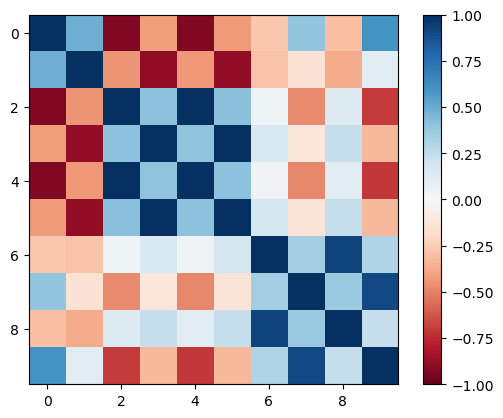

In [99]:
plt.imshow(fNL_corr, vmin=-1, vmax=1, cmap="RdBu")
plt.colorbar()

[[ 1.         -0.92555776 -0.92473523]
 [-0.92555776  1.          0.99974537]
 [-0.92473523  0.99974537  1.        ]]


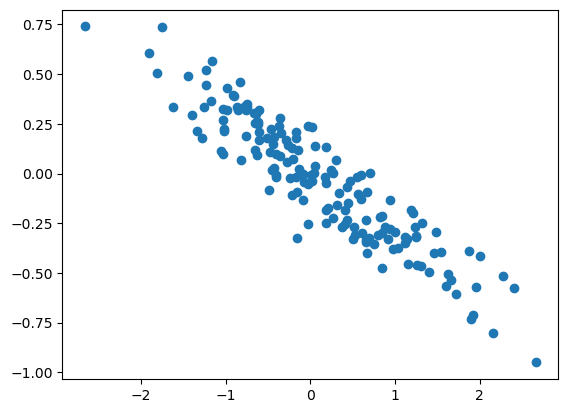

In [11]:
local = result_TP.loc[result_TP["shape_name"]=="local sin", "single_f_NL"].to_numpy()
equil = result_TP.loc[result_TP["shape_name"]=="equilateral sin", "single_f_NL"].to_numpy()
ortho = result_TP.loc[result_TP["shape_name"]=="orthogonal sin", "single_f_NL"].to_numpy()

print(np.corrcoef(np.vstack([local, equil, ortho])))


plt.scatter(local, equil)

In [28]:
# Compute shape correlation
shape_norm = np.sqrt(np.diag(shape_cov))
shape_corr = shape_cov / (shape_norm[:,np.newaxis] * shape_norm[np.newaxis,:])

# Visualise
shape_names = [model.shape_name for model in models]
df = pd.DataFrame(shape_corr, columns=shape_names)
df.insert(0, "Name", shape_names)
df

,Name,local,equilateral,orthogonal,sin 10,cos 10,sin 20,cos 20,sin 30,cos 30,...,sin 250,cos 250,sin 260,cos 260,sin 270,cos 270,sin 280,cos 280,sin 290,cos 290
0,local,1.0e+00,2.8e-01,-3.4e-01,-1.5e-01,-3.5e-01,1.3e-01,1.6e-02,-4.1e-02,5.5e-02,...,-5.8e-04,-1.8e-03,1.7e-03,3.9e-04,-1.1e-03,1.2e-03,-4.3e-04,-1.5e-03,1.4e-03,3.7e-04
1,equilateral,2.8e-01,1.0e+00,1.8e-01,-5.0e-01,-5.3e-01,1.5e-01,-1.8e-01,6.7e-02,5.1e-02,...,-9.5e-05,1.5e-04,-3.4e-05,-1.3e-04,1.5e-04,3.8e-05,-6.8e-05,1.1e-04,-2.6e-05,-9.6e-05
2,orthogonal,-3.4e-01,1.8e-01,1.0e+00,-8.4e-02,4.4e-01,-2.2e-01,-2.0e-01,1.6e-01,-1.2e-01,...,2.0e-03,2.9e-03,-3.2e-03,2.3e-04,1.3e-03,-2.6e-03,1.5e-03,2.3e-03,-2.5e-03,1.1e-04
3,sin 10,-1.5e-01,-5.0e-01,-8.4e-02,1.0e+00,1.8e-01,-5.4e-01,3.3e-01,-3.7e-02,-2.1e-01,...,1.3e-03,1.3e-03,-1.6e-03,3.7e-04,4.8e-04,-1.5e-03,9.5e-04,1.1e-03,-1.3e-03,2.4e-04
4,cos 10,-3.5e-01,-5.3e-01,4.4e-01,1.8e-01,1.0e+00,-3.5e-01,-4.3e-01,1.6e-01,-9.0e-02,...,6.5e-04,9.9e-04,-1.1e-03,6.3e-05,4.8e-04,-8.7e-04,5.0e-04,7.9e-04,-8.5e-04,2.8e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,cos 270,1.2e-03,3.8e-05,-2.6e-03,-1.5e-03,-8.7e-04,1.5e-03,-9.3e-04,7.9e-05,1.8e-03,...,-1.8e-01,-6.3e-02,3.4e-01,-4.9e-01,-1.4e-04,1.0e+00,-3.4e-01,-4.9e-01,1.8e-01,-6.3e-02
57,sin 280,-4.3e-04,-6.8e-05,1.5e-03,9.5e-04,5.0e-04,-8.5e-04,7.2e-04,-2.6e-04,-1.1e-03,...,7.7e-02,-2.8e-03,-6.3e-02,1.8e-01,-4.9e-01,-3.4e-01,1.0e+00,2.0e-04,-4.9e-01,3.4e-01
58,cos 280,-1.5e-03,1.1e-04,2.3e-03,1.1e-03,7.9e-04,-1.3e-03,5.3e-04,2.9e-04,-1.4e-03,...,3.2e-03,7.7e-02,-1.8e-01,-6.3e-02,3.4e-01,-4.9e-01,2.0e-04,1.0e+00,-3.4e-01,-4.9e-01
59,sin 290,1.4e-03,-2.6e-05,-2.5e-03,-1.3e-03,-8.5e-04,1.4e-03,-7.4e-04,-1.1e-04,1.6e-03,...,-2.5e-02,-3.2e-02,7.7e-02,-3.1e-03,-6.3e-02,1.8e-01,-4.9e-01,-3.4e-01,1.0e+00,-5.5e-05


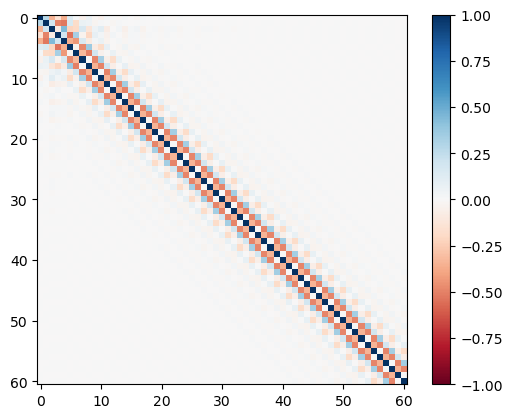

In [29]:
plt.imshow(shape_corr, vmin=-1, vmax=1, cmap="RdBu")
plt.colorbar()

Some results for feature models, with $p_{max} = 10$

In [14]:
# Show results
result_T["S/N"] = result_T["single_f_NL"] / result_T["single_sample_sigma"]
result_T[["shape_name", "convergence_MSE", "single_f_NL", "single_sample_sigma", "S/N"]]

,shape_name,convergence_MSE,single_f_NL,single_sample_sigma,S/N
0,local,2.6e-04,-3.7,6.4,-5.9e-01
1,equilateral,2.1e-07,14.7,65.7,2.2e-01
2,orthogonal,1.7e-05,-1.7,40.4,-4.2e-02
3,sin 10,2.6e-06,43.2,63.8,6.8e-01
4,cos 10,4.2e-06,60.3,72.0,8.4e-01
5,sin 20,3.4e-06,-6.2,62.7,-9.9e-02
6,cos 20,3.4e-06,-6.6,66.8,-9.9e-02
7,sin 30,4.2e-06,51.3,67.7,7.6e-01
8,cos 30,2.6e-06,23.9,80.3,3.0e-01
9,sin 40,1.5e-06,54.5,91.1,6.0e-01


In [5]:
# Show results
result_TP["S/N"] = result_TP["single_f_NL"] / result_TP["single_sample_sigma"]
result_TP[["shape_name", "convergence_MSE", "single_f_NL", "single_sample_sigma", "S/N"]]

,shape_name,convergence_MSE,single_f_NL,single_sample_sigma,S/N
0,local,2.6e-04,-2.7,5.3,-0.5
1,equilateral,2.1e-07,-22.0,49.0,-0.4
2,orthogonal,1.7e-05,-29.1,24.0,-1.2
3,sin 10,2.6e-06,20.2,42.9,0.5
4,cos 10,4.2e-06,53.4,46.1,1.2
5,sin 20,3.4e-06,29.7,37.4,0.8
6,cos 20,3.4e-06,-20.0,46.5,-0.4
7,sin 30,4.2e-06,-19.2,43.8,-0.4
8,cos 30,2.6e-06,8.4,44.3,0.2
9,sin 40,1.5e-06,59.3,51.1,1.2


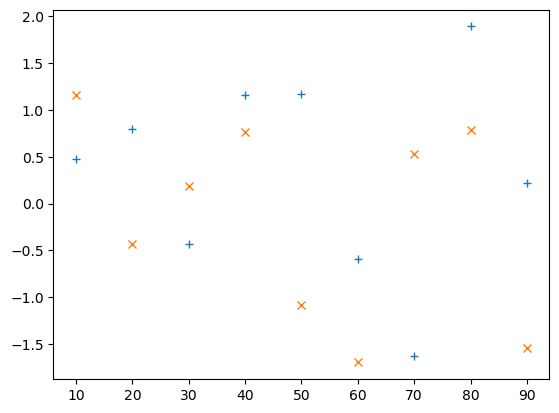

In [10]:
plt.plot(omegas, result_TP["S/N"].to_numpy()[3::2], "+")
plt.plot(omegas, result_TP["S/N"].to_numpy()[4::2], "x")

In [11]:
# Compute shape correlation
shape_norm = np.sqrt(np.diag(shape_cov))
shape_corr = shape_cov / (shape_norm[:,np.newaxis] * shape_norm[np.newaxis,:])

# Visualise
shape_names = [model.shape_name for model in models]
df = pd.DataFrame(shape_corr, columns=shape_names)
df.insert(0, "Name", shape_names)
df

,Name,local,equilateral,orthogonal,sin 10,cos 10,sin 20,cos 20,sin 30,cos 30,...,sin 50,cos 50,sin 60,cos 60,sin 70,cos 70,sin 80,cos 80,sin 90,cos 90
0,local,1.0e+00,2.8e-01,-3.4e-01,-1.5e-01,-3.5e-01,1.3e-01,1.6e-02,-4.1e-02,5.5e-02,...,3.0e-02,2.6e-03,-1.3e-02,1.8e-02,-7.4e-03,-1.6e-02,1.4e-02,1.1e-03,-6.4e-03,9.3e-03
1,equilateral,2.8e-01,1.0e+00,1.8e-01,-5.0e-01,-5.3e-01,1.5e-01,-1.8e-01,6.7e-02,5.1e-02,...,3.7e-03,-1.7e-02,1.1e-02,5.2e-03,-4.5e-03,4.1e-03,1.6e-04,-4.5e-03,3.7e-03,1.3e-03
2,orthogonal,-3.4e-01,1.8e-01,1.0e+00,-8.4e-02,4.4e-01,-2.2e-01,-2.0e-01,1.6e-01,-1.2e-01,...,-7.4e-02,-4.6e-03,3.0e-02,-4.8e-02,2.3e-02,3.5e-02,-3.2e-02,2.5e-03,1.1e-02,-2.3e-02
3,sin 10,-1.5e-01,-5.0e-01,-8.4e-02,1.0e+00,1.8e-01,-5.4e-01,3.3e-01,-3.7e-02,-2.1e-01,...,-4.3e-02,3.0e-02,-2.4e-03,-3.6e-02,2.2e-02,1.1e-02,-1.6e-02,9.4e-03,2.4e-04,-1.5e-02
4,cos 10,-3.5e-01,-5.3e-01,4.4e-01,1.8e-01,1.0e+00,-3.5e-01,-4.3e-01,1.6e-01,-9.0e-02,...,-3.5e-02,-6.4e-03,1.6e-02,-2.0e-02,9.0e-03,1.6e-02,-1.2e-02,6.5e-05,5.2e-03,-8.5e-03
5,sin 20,1.3e-01,1.5e-01,-2.2e-01,-5.4e-01,-3.5e-01,1.0e+00,-3.2e-02,-4.8e-01,3.6e-01,...,8.4e-02,-7.6e-03,-2.1e-02,4.2e-02,-1.9e-02,-2.7e-02,2.3e-02,-3.7e-03,-6.4e-03,1.6e-02
6,cos 20,1.6e-02,-1.8e-01,-2.0e-01,3.3e-01,-4.3e-01,-3.2e-02,1.0e+00,-3.2e-01,-5.0e-01,...,-1.4e-02,6.9e-02,-2.2e-02,-3.0e-02,2.6e-02,-2.4e-03,-6.8e-03,1.5e-02,-5.4e-03,-1.0e-02
7,sin 30,-4.1e-02,6.7e-02,1.6e-01,-3.7e-02,1.6e-01,-4.8e-01,-3.2e-01,1.0e+00,-1.5e-03,...,-5.9e-02,-1.7e-01,6.9e-02,2.0e-03,-2.1e-02,2.7e-02,-8.9e-03,-2.1e-02,1.5e-02,7.6e-04
8,cos 30,5.5e-02,5.1e-02,-1.2e-01,-2.1e-01,-9.0e-02,3.6e-01,-5.0e-01,-1.5e-03,1.0e+00,...,1.9e-01,-6.6e-02,-4.0e-03,8.4e-02,-3.7e-02,-2.9e-02,3.2e-02,-1.3e-02,-2.2e-03,2.4e-02
9,sin 40,-1.8e-02,-2.4e-02,4.7e-02,8.5e-02,2.4e-02,-8.1e-02,1.8e-01,-4.8e-01,-3.5e-01,...,-5.0e-01,3.4e-01,-5.9e-02,-1.9e-01,7.8e-02,8.4e-03,-3.0e-02,3.1e-02,-8.2e-03,-2.9e-02


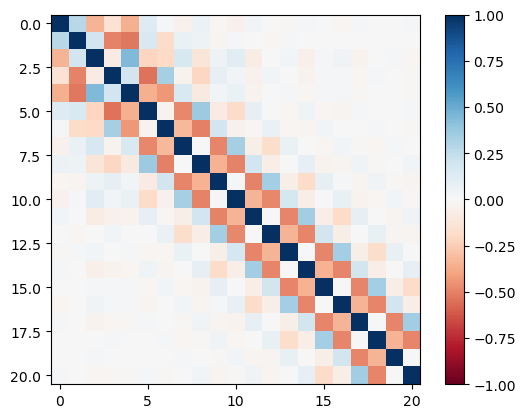

In [12]:
plt.imshow(shape_corr, vmin=-1, vmax=1, cmap="RdBu")
plt.colorbar()